# Project X - Chicago Beach Water Quality 
#### This notebook analyzes the water quality of Chicago beaches with various graphs and plots so that beach goers can make a better informed decision.


### TL;DR : 
* (read first paragraph of Purpose and Data section)
* Data reading for DNA pathogen levels do not have an extensive history as only a few beaches started sampling in 2015. Therefore, there is no real determination on increasing or decreasing levels of DNA readings.
* Every beach will be at safe levels on average, while Humboldt poses the highest risk.
* Foster, North Avenue, Oak Street beach are the "safest" beaches as they have remained under the advisory limit.
* Humboldt is the worst performing "beach" in regards to safe levels on average. 
* DNA levels vary beach by beach throughout the week (see Weekly Average Readings)

## Sections:
* Purpose and Data
* Preprocessing
* Chicago Beach Locations
* All-Time DNA Averages
* Percentiles
* Weekly Average Readings
* Good and Bad Days

In [19]:
# ~ projectX.R
#
# Raymond Hruby II
# UIC CS 424 Visual Analytics 
# 5/3/2019

In [1]:
library(dplyr) #data frame manip.
library(purrr) #!!! operator
library(leaflet) #maps
library(ggplot2) #graphs & plots
library(scales) #for ggplot2
library(lubridate) #dates
library(reshape2) #melt
library(gridExtra)#plot arrangement


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



# Purpose and Data
This data is gathered from various Chicago beaches over a timeline testing for pathogenic DNA (microbial organisms). Advisory levels of this DNA are those exceeding 1000 Calibrator Cell Equivalents (CCE) as recommended by the UPEPA. Contaminated water can make people ill. To better understand what this means for safe beaches we will analyze the data gathered by City Of Chicago.

Link to Data: https://www.epa.gov/wqc/microbial-pathogenrecreational-water-quality-criteria

We will begin by gathering the data:


In [2]:
#columns to keep from dataset
starCols = c("DNA.Sample.Timestamp","Beach","DNA.Reading.Mean","Latitude","Longitude")
#reading in stored dataset
df <- read.csv(file = "http://www.evl.uic.edu/aej/424/chicagobeach.csv", header = TRUE, stringsAsFactors=FALSE) %>%
    select(starCols)%>%rename(Timestamp = DNA.Sample.Timestamp, DNA.Mean = DNA.Reading.Mean)
head(df)

#getting beach names
beaches <- df %>% distinct(Beach,Latitude,Longitude)
beaches

Timestamp,Beach,DNA.Mean,Latitude,Longitude
09/03/2018 12:00:00 AM,12th Street,133.7,41.8638,-87.6083
09/03/2018 12:00:00 AM,57th Street,182.4,41.7911,-87.5797
09/03/2018 12:00:00 AM,63rd Street,404.5,41.7827,-87.5748
09/03/2018 12:00:00 AM,Calumet,440.5,41.7142,-87.5299
09/03/2018 12:00:00 AM,Foster,140.3,41.9785,-87.6515
09/03/2018 12:00:00 AM,Hartigan (Albion),592.2,42.0027,-87.6564


Beach,Latitude,Longitude
12th Street,41.86380,-87.60830
57th Street,41.79110,-87.57970
63rd Street,41.78270,-87.57480
Calumet,41.71420,-87.52990
Foster,41.97850,-87.65150
Hartigan (Albion),42.00270,-87.65640
Howard,42.01880,-87.66630
Humboldt,41.90643,-87.70372
Leone,42.01310,-87.66350
Margaret T Burroughs (31st),41.83930,-87.60720


## Preprocessing

We can see that some beach names are similar so we will fix their names, latitude, and longitude while retaining other data (on earlier inspection, these odd named data rows do not conflict with their common and current name)

In [3]:
#renaming odd names to similar names that contain the location of the beach
for (row in 1:nrow(df)){
  if(df[row,"Beach"]=="Margaret T Burroughs"){
    df[row,"Beach"]<-"Margaret T Burroughs (31st)"
    df[row,"Latitude"]<-subset(beaches,Beach=="Margaret T Burroughs (31st)",select=Latitude)
    df[row,"Longitude"]<-subset(beaches,Beach=="Margaret T Burroughs (31st)",select=Longitude)
  }
  if(df[row,"Beach"]=="Hartigan"){
    df[row,"Beach"]<-"Hartigan (Albion)"
    df[row,"Latitude"]<-subset(beaches,Beach=="Hartigan (Albion)",select=Latitude)
    df[row,"Longitude"]<-subset(beaches,Beach=="Hartigan (Albion)",select=Longitude)
  }
  if(df[row,"Beach"]=="Marion Mahony Griffin"){
    df[row,"Beach"]<-"Marion Mahony Griffin (Jarvis)"
    df[row,"Latitude"]<-subset(beaches,Beach=="Marion Mahony Griffin (Jarvis)",select=Latitude)
    df[row,"Longitude"]<-subset(beaches,Beach=="Marion Mahony Griffin (Jarvis)",select=Longitude)
  }
}
#getting POSIX representation of date time from character representation
df$Timestamp <- mdy_hms(df$Timestamp)
#getting beach names
beaches <- df %>% distinct(Beach,Latitude,Longitude)
beaches

Beach,Latitude,Longitude
12th Street,41.86380,-87.60830
57th Street,41.79110,-87.57970
63rd Street,41.78270,-87.57480
Calumet,41.71420,-87.52990
Foster,41.97850,-87.65150
Hartigan (Albion),42.00270,-87.65640
Howard,42.01880,-87.66630
Humboldt,41.90643,-87.70372
Leone,42.01310,-87.66350
Margaret T Burroughs (31st),41.83930,-87.60720


After updating the original beaches object we can see that the data with odd names have been renamed to their counterpart.

# Chicago Beach Locations

In [4]:
# leaflet map showing all beaches
library(leaflet) #maps
mapBase <- leaflet(beaches) %>% 
  addTiles() %>%
  addMarkers(lng= ~Longitude, lat= ~Latitude, label= ~Beach, popup= ~Beach)
mapBase

HTML widgets cannot be represented in plain text (need html)

Now we will display each beach with there all-time DNA averages

# All-Time DNA Averages

In [5]:
#getting mean for each beach over all the data
beachesAllTimeSummary <- df %>% 
  group_by(Beach) %>% 
  summarise(
    DNA.Mean = mean(DNA.Mean)
  ) %>% 
  merge(beaches,by ="Beach",all=TRUE)

#functions for leaflet mapAllTime
colorSet <- c("#FFFFCC","#FFD633","#FF8533","#FF3333")
colorLabels <-c("0-599","600-899","900-999","1000-above")
getColor<-function(DNA.Mean,colors){
  # 0-599,600-899,900-999,1000->
  if(DNA.Mean <= 599){colorSet[1]}
  else if(DNA.Mean <= 899){colorSet[2]}
  else if(DNA.Mean <= 999){colorSet[3]}
  else {colorSet[4]}
}

# leaflet map of all time averages for Beaches
mapAllTime <- leaflet(beachesAllTimeSummary) %>% addTiles()
for(row in 1:nrow(beachesAllTimeSummary)){
  rowColor = getColor(beachesAllTimeSummary[row,"DNA.Mean"], colorSet)
  mapAllTime <- addCircleMarkers(mapAllTime, lng=beachesAllTimeSummary[row, "Longitude"], lat=beachesAllTimeSummary[row, "Latitude"], 
                                 color=rowColor, 
                                 fillOpacity = 0.9,
                                 label= beachesAllTimeSummary[row,"Beach"],
                                 popup= paste("Name:",beachesAllTimeSummary[row,"Beach"],"<br>",
                                              "Average:",beachesAllTimeSummary[row,"DNA.Mean"],"<br>"))
}
mapAllTime <- addLegend(mapAllTime,colors=colorSet, labels=colorLabels,
                        title = "All Time DNA Averages (CCE)", opacity = 1
)
mapAllTime

HTML widgets cannot be represented in plain text (need html)

But if we plot all the data for each beach, we can easily see there are some outrageous outliers for a handful of beaches (remember, above 1000 CCE is considered unsafe which is indicated by the red line in the next plots), especially for the most current years:


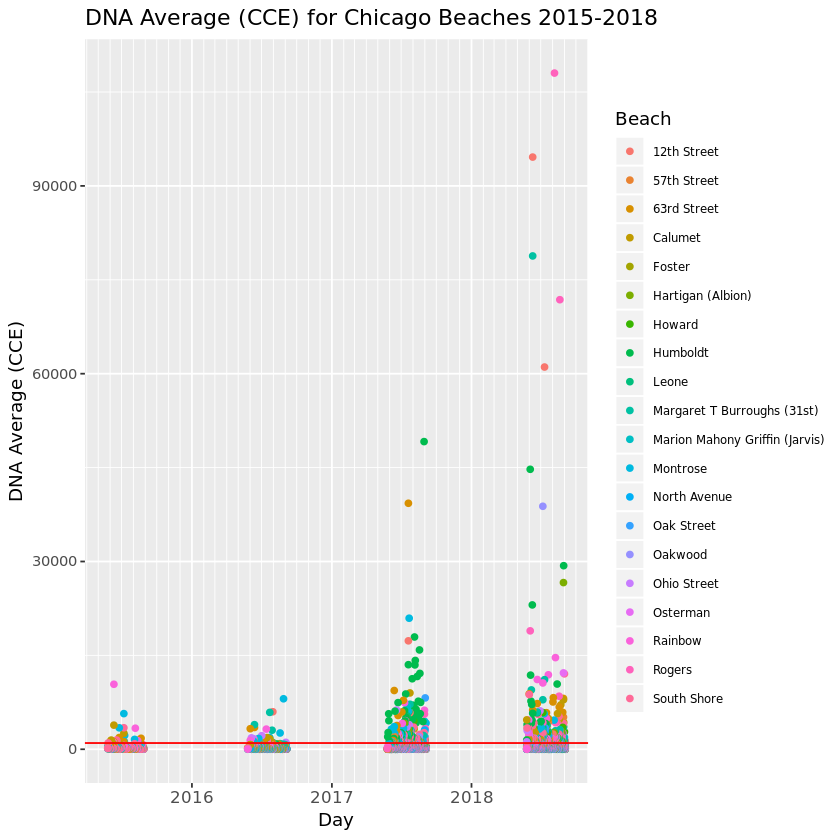

In [6]:
#subsetting data to be fit for plotting
dfSkim <- subset(df,select = -c(Latitude,Longitude))

ggplot(data=dfSkim, aes(x=Timestamp,y=DNA.Mean,group=Beach))+
  geom_point(aes(color = Beach)) +
  xlab("Day") + ylab("DNA Average (CCE)") +
  theme(axis.text.x = element_text(size=10))+
  theme(legend.text=element_text(size=7))+
  geom_hline(yintercept=1000,color = "red")+
  ggtitle("DNA Average (CCE) for Chicago Beaches 2015-2018")+ 
  scale_x_datetime(date_labels="%Y",date_breaks="1 year",date_minor_break="1 month")

We can see that it appears the readings are getting worse, but we will have to deal with the outliers in order to form this conclusion. We can also see the readings only take place between a short range of months in the graph, May through September, when the water temperature is suitable for swimming in. We can confirm this:

In [7]:
paste0("DNA Reading Range:   ", min(df$Timestamp), " to ",max(df$Timestamp))

[1] "DNA Reading Range:   2015-05-26 to 2018-09-03"





# Percentiles

Now we will be setting up percentiles to see a range without outliers, where the outliers may contain unreliable data and distort the Average seen previously, and also to see the most common data range.

In [8]:
# DONT WORRY ABOUT WARNING
#This is setting up a function to calculate the percentiles per beach, that will be called next when creating the data table.

#percentiles for ranges 90%(.05-.95) 10%(.45,.55)
p <- c(.05,.45,.55,.95)
p_names <- map_chr(p, ~paste0("p",.x*100))
p_funs <- map(p, ~partial(quantile, probs=.x,na.rm=TRUE)) %>%
  set_names(nm = p_names)

#Setting up table of percentiles
beachesPercentiles <- df %>%
  group_by(Beach) %>%
  summarise_at(
    vars(DNA.Mean),funs(!!!p_funs)
  ) %>%
  merge(beaches, by ="Beach", all=TRUE)

Warning message:
“funs() is soft deprecated as of dplyr 0.8.0
please use list() instead

# Before:
funs(name = f(.)

# After: 
list(name = ~f(.))
This warning is displayed once per session.”

Now we can create new plots considering the percentile ranges:


Beach,p5,p45,p55,p95
12th Street,8.500,67.180,87.580,1036.320
57th Street,12.320,178.800,229.560,1427.760
63rd Street,23.225,180.815,250.875,3472.100
Calumet,17.630,152.475,225.675,2456.620
Foster,24.910,119.245,150.345,779.925
Hartigan (Albion),22.120,203.100,271.230,1448.010


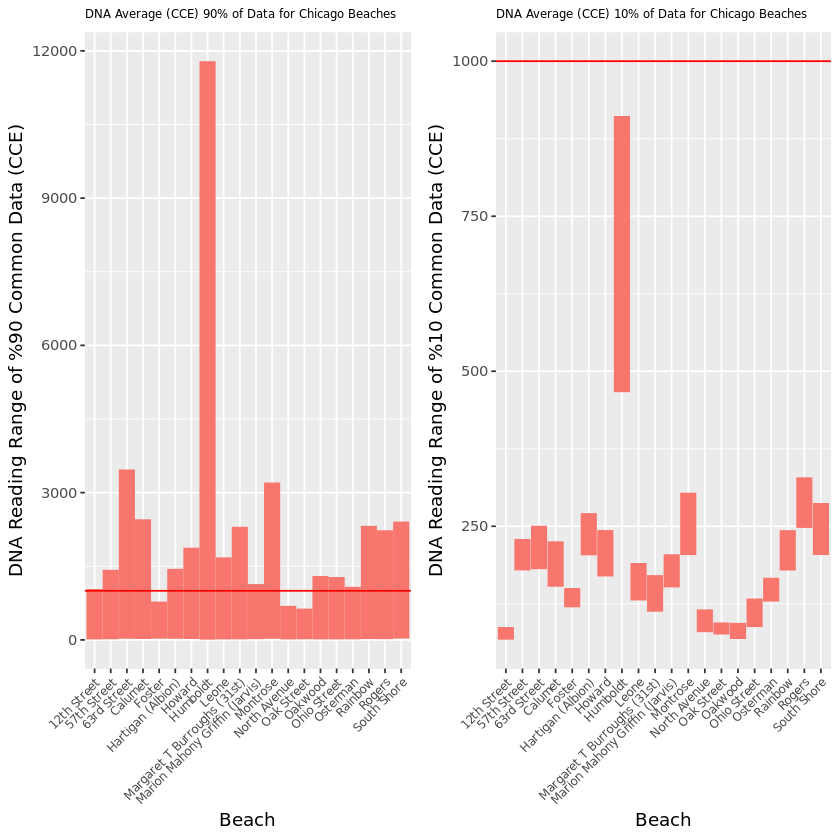

In [9]:
beachesPSkim <- subset(beachesPercentiles,select = -c(Latitude,Longitude))
head(beachesPSkim)

rA90<-ggplot(data=beachesPSkim)+
          geom_linerange(aes(x=Beach, ymin=p5, ymax=p95, colour="red", size=2))+
          guides(colour="none",size="none")+
          ylab("DNA Reading Range of %90 Common Data (CCE)")+
          theme(axis.text.x = element_text(size=7,angle=45,hjust=1))+
          theme(plot.title = element_text(size=7))+
          geom_hline(yintercept=1000,color = "red")+
          ggtitle(paste0("DNA Average (CCE) 90% of Data for Chicago Beaches"))

rA10<-ggplot(data=beachesPSkim)+
          geom_linerange(aes(x=Beach, ymin=p45, ymax=p55, colour="red", size=2))+
          guides(colour="none",size="none")+
          ylab("DNA Reading Range of %10 Common Data (CCE)")+
          theme(axis.text.x = element_text(size=7,angle=45,hjust=1))+
          theme(plot.title = element_text(size=7))+
          geom_hline(yintercept=1000,color = "red")+
          ggtitle(paste0("DNA Average (CCE) 10% of Data for Chicago Beaches"))

grid.arrange(rA90,rA10,ncol=2)



By the first plot, there is still much outlying data. But this range is more true to the common readings than using all the readings.

By the second plot, we can see the most common levels of DNA pathogen readings in each beach. In conclusion, these readings are well below the 1000 CCE advisory limit, except for Humboldt where the top of the average range almost reaches the advisory limit.
As Humboldt Beach isn't really a beach, having water being contained in such a small area is likely the reason why the DNA Readings are higher. 
#### Therefore, every beach will be at safe levels on average where Humboldt poses the highest risk.


We can specifically see which Beaches have a range over and under the Advisory limit for the 90% common data.

In [10]:
beachRangeOver <- filter(beachesPSkim,p95>1000) %>% select(Beach) %>% rename("Beach Range Over Advisory (%90)" = Beach)
beachRangeOver
beachRangeUnder <- filter(beachesPSkim,p95<1000) %>% select(Beach) %>% rename("Beach Range Under Advisory (%90)" = Beach)
beachRangeUnder


Beach Range Over Advisory (%90)
12th Street
57th Street
63rd Street
Calumet
Hartigan (Albion)
Howard
Humboldt
Leone
Margaret T Burroughs (31st)
Marion Mahony Griffin (Jarvis)


Beach Range Under Advisory (%90)
Foster
North Avenue
Oak Street


#### As Foster, North Avenue, Oak Street beach are under the advisory for at least 90% of their readings, they can be concluded to be the "safest" beaches.

We can revisit the line graph of DNA averages with these new ranges of DNA Mean values considering the percentiles:

In [11]:
#setting up data frames with DNA mean values between percentile ranges
df90 <- merge(dfSkim,beachesPercentiles,by="Beach",all=TRUE)
df90 <- df90 %>%
  group_by(Beach) %>%
  filter(
    (DNA.Mean>p5)&(DNA.Mean<p95)
  )

df10 <- merge(dfSkim,beachesPercentiles,by="Beach",all=TRUE)
df10 <- df10 %>%
  group_by(Beach) %>%
  filter(
    (DNA.Mean>p45)&(DNA.Mean<p55)
  )
df90 <- df90[,c("Beach","Timestamp","DNA.Mean")]
df10 <- df10[,c("Beach","Timestamp","DNA.Mean")]

paste("90% Range: ",min(df90$DNA.Mean),"-",max(df90$DNA.Mean))
paste("10% Range: ",min(df10$DNA.Mean),"-",max(df10$DNA.Mean))

[1] "90% Range:  5 - 11627.5"

[1] "10% Range:  67.7 - 908.5"

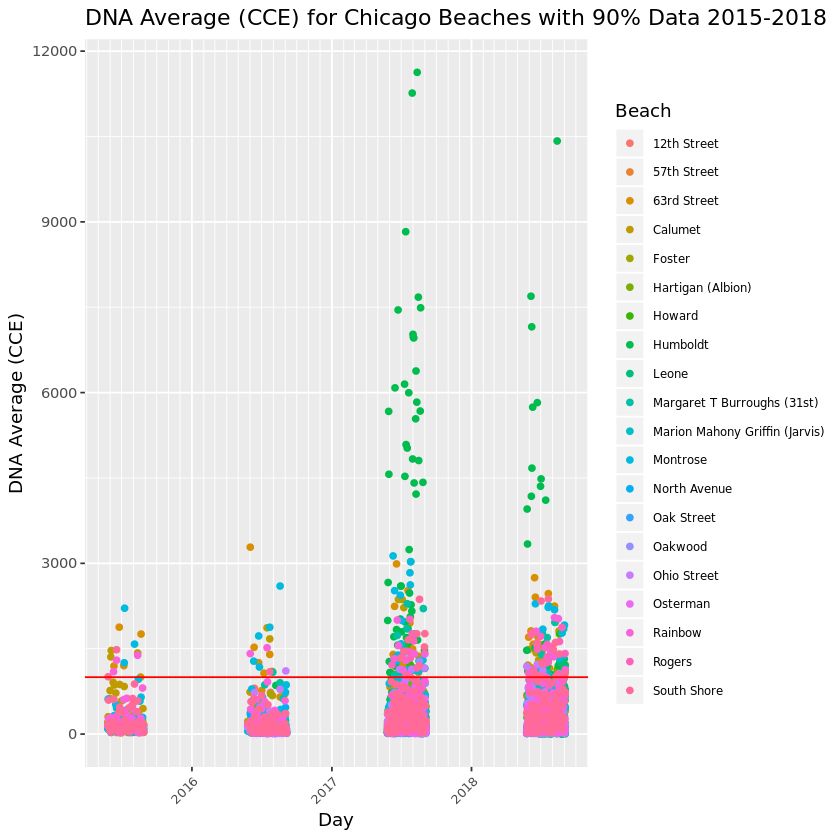

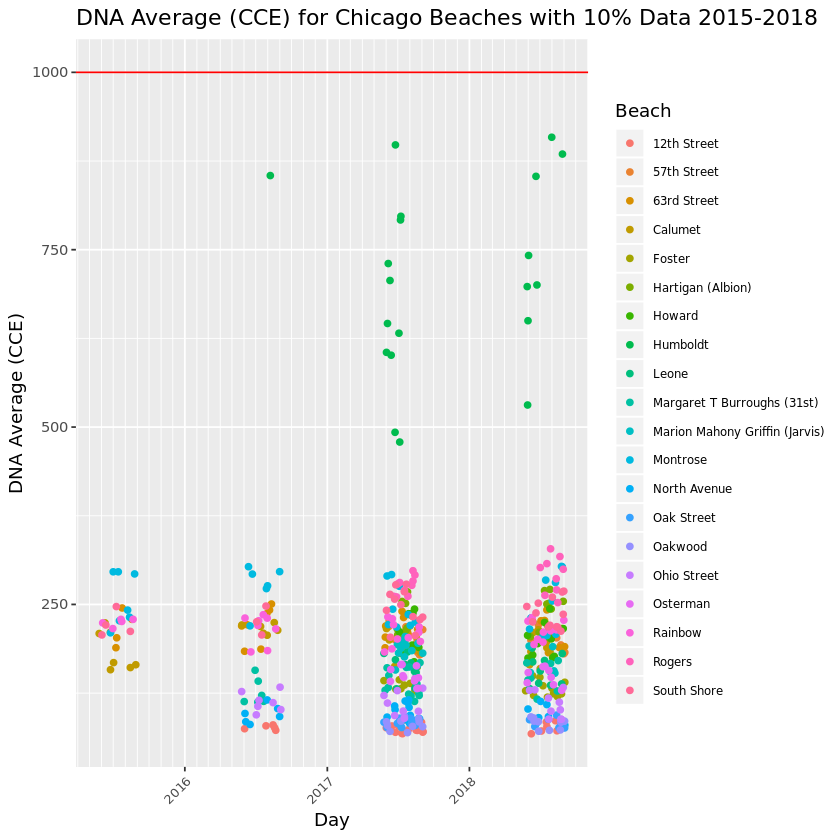

In [12]:
plotLineAvg <- function(df,type){
    plot_LineAvg<- ggplot(data=df, aes(x=Timestamp,y=DNA.Mean,group=Beach))+
      geom_point(aes(color = Beach)) +
      xlab("Day") + ylab("DNA Average (CCE)") +
      theme(axis.text.x = element_text(size=8,angle=45,hjust=1))+
      theme(legend.text=element_text(size=7))+
      geom_hline(yintercept=1000,color = "red")+
      ggtitle(paste0("DNA Average (CCE) for Chicago Beaches with ",type,"% Data 2015-2018"))+ 
      scale_x_datetime(date_labels="%Y",date_breaks="1 year",date_minor_break="1 month")
}

la90 <- plotLineAvg(df90,"90")
la10 <- plotLineAvg(df10,"10")

#plots not visible
#grid.arrange(plot_LineAvg90,plot_LineAvg10,ncol=2)

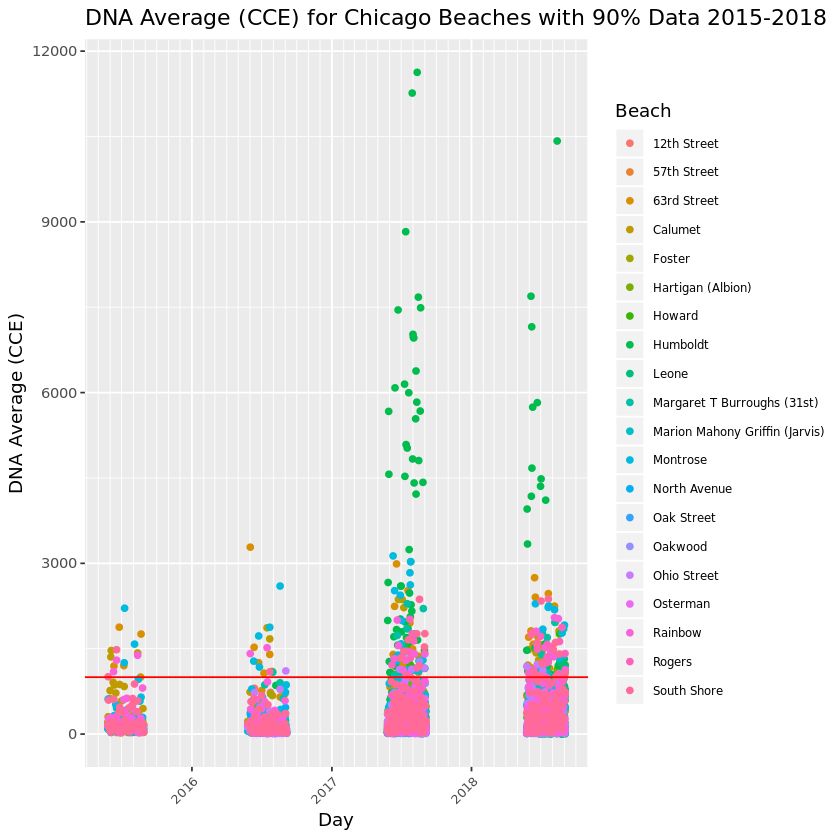

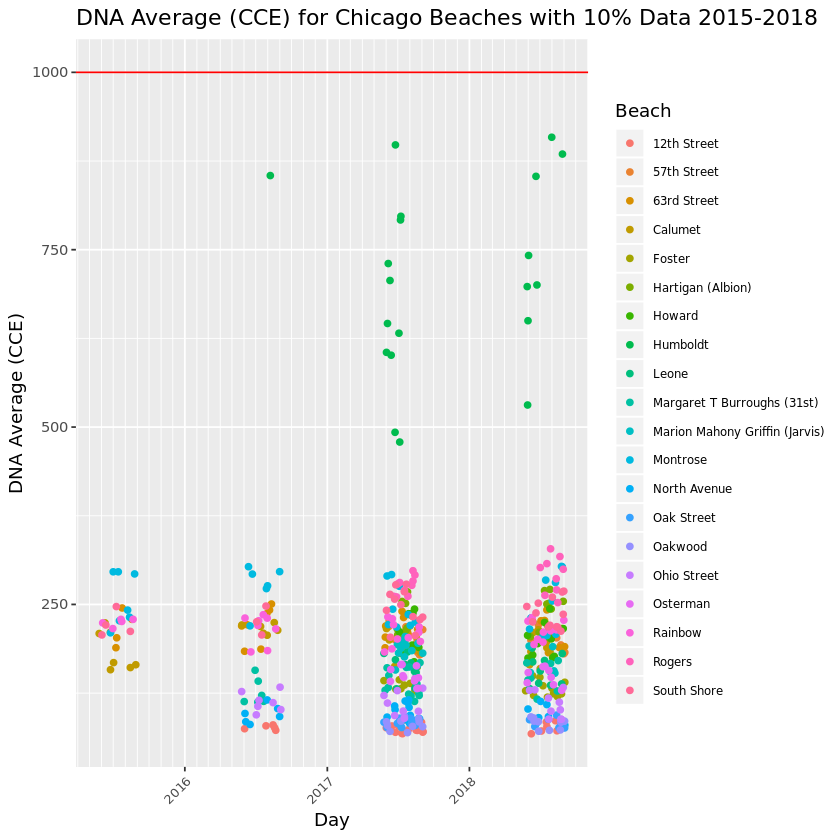

In [13]:
la90
la10

By viewing the 'DNA Average 10% plot, it becomes clear to see that Humboldt DNA readings are well above the others. 
#### We can also see that this data reading process is fairly new with fewer readings for 2015 and 2016, so there is not really anything we can deduce from changes in the timeline.

# Weekly Average Readings

We can see if this is more better explained by viewing the data by week.

In [14]:
# WAIT FOR SECTION TO LOAD, LONG LOAD TIME

#adding week day column to datasets
df90$Day<-wday(df90$Timestamp,label=TRUE,abbr=FALSE)
#head(df90)
df10$Day<-wday(df10$Timestamp,label=TRUE,abbr=FALSE)
#head(df10)

#getting mean for each beach over all the data
getWeeklyMean <- function(df,beaches){
    beachesWeeklyMean<- df %>% 
      group_by(Beach,Day) %>% 
      summarise(
        DNA.Mean = mean(DNA.Mean)
      ) %>% 
      merge(beaches,by ="Beach",all=TRUE)
    return(beachesWeeklyMean)
}
beachesWeeklyMean90 <- getWeeklyMean(df90,beaches)
beachesWeeklyMean10 <- getWeeklyMean(df10,beaches)
head(beachesWeeklyMean90)
head(beachesWeeklyMean10)

Beach,Day,DNA.Mean,Latitude,Longitude
12th Street,Sunday,178.1086,41.8638,-87.6083
12th Street,Monday,142.6357,41.8638,-87.6083
12th Street,Tuesday,113.9400,41.8638,-87.6083
12th Street,Wednesday,202.1600,41.8638,-87.6083
12th Street,Thursday,120.4895,41.8638,-87.6083
12th Street,Friday,204.3171,41.8638,-87.6083


Beach,Day,DNA.Mean,Latitude,Longitude
12th Street,Sunday,73.00000,41.8638,-87.6083
12th Street,Monday,74.60000,41.8638,-87.6083
12th Street,Tuesday,76.10000,41.8638,-87.6083
12th Street,Wednesday,78.90000,41.8638,-87.6083
12th Street,Thursday,75.92222,41.8638,-87.6083
12th Street,Friday,81.80000,41.8638,-87.6083


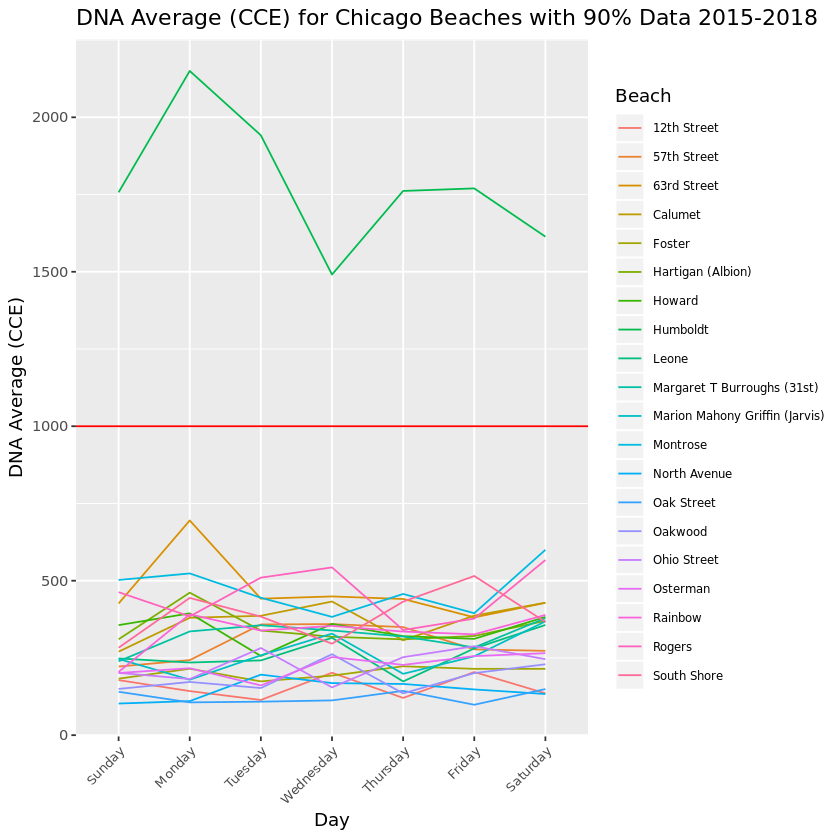

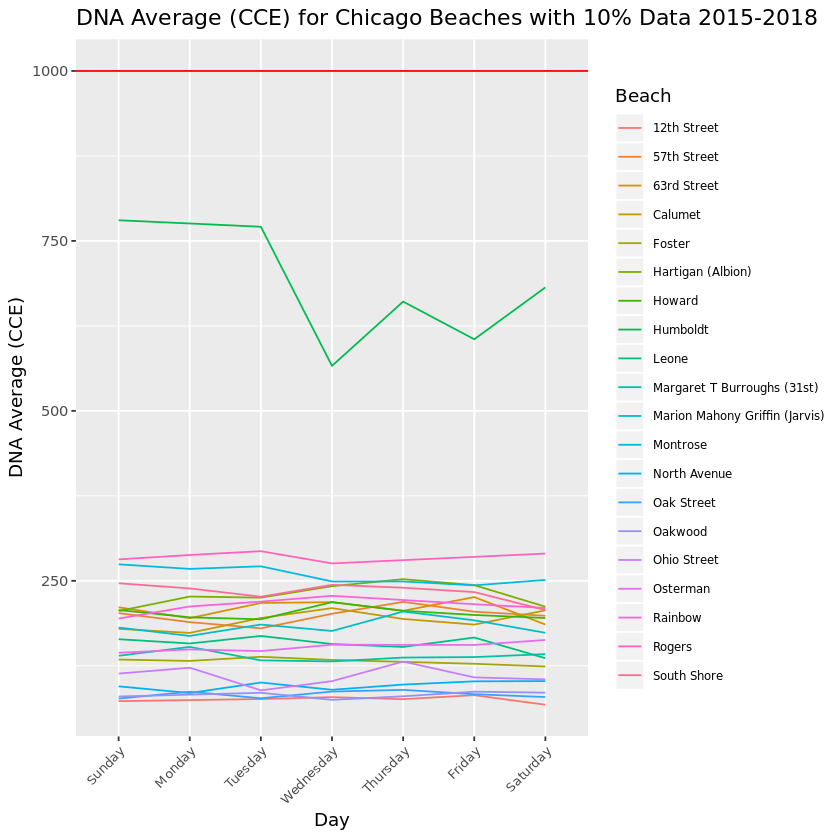

In [15]:
plotWeeklyMean<-function(df,type){
    plot_WeekAvg<- ggplot(data=df, aes(x=Day,y=DNA.Mean,group=Beach))+
      geom_line(aes(color = Beach)) +
      xlab("Day") + ylab("DNA Average (CCE)") +
      theme(axis.text.x = element_text(size=8,angle=45,hjust=1))+
      theme(legend.text=element_text(size=7))+
      geom_hline(yintercept=1000,color = "red")+
      ggtitle(paste0("DNA Average (CCE) for Chicago Beaches with ",type,"% Data 2015-2018"))
    return(plot_WeekAvg)
}

wM90 <- plotWeeklyMean(beachesWeeklyMean90,"90")
wM10 <- plotWeeklyMean(beachesWeeklyMean10,"10")

wM90
wM10

Paying more attention to the %90 Common Data plot is beneficial here as it contains enough data points for each weekday to sufficiently determine a more accurate average.

Next, we can show each beach by itself to get a sense of their specific rises and dips in readings thoughout the week

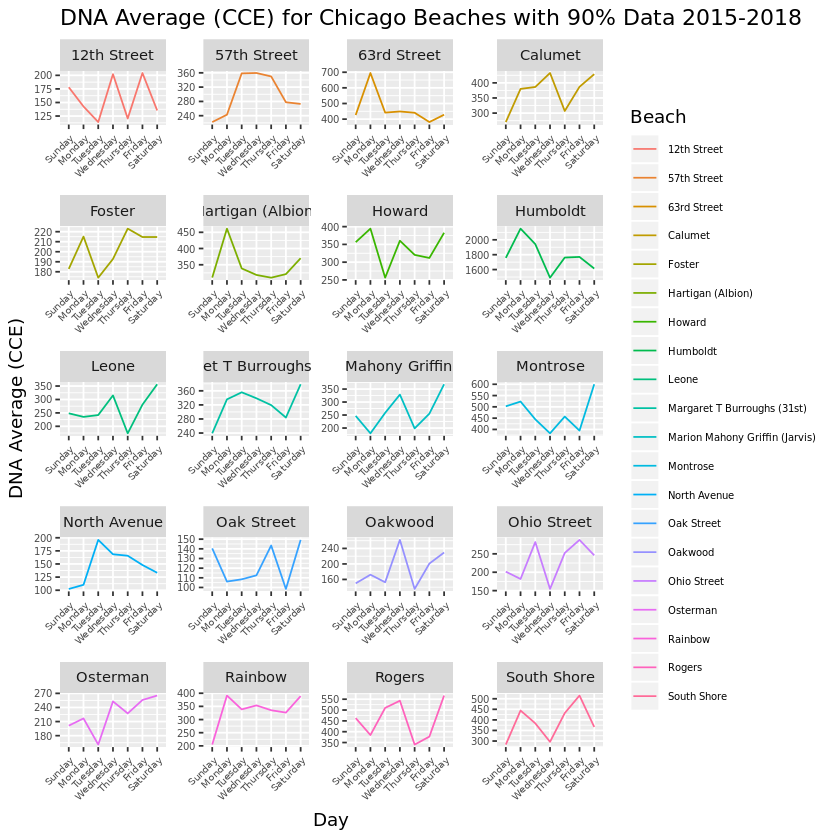

In [16]:
#weekly plots separated by Beach
wM90Facet <- ggplot(data=beachesWeeklyMean90, aes(x=Day,y=DNA.Mean,group=Beach))+
          geom_line(aes(color = Beach)) +
          xlab("Day") + ylab("DNA Average (CCE)") +
          theme(axis.text.x = element_text(size=6,angle=45,hjust=1))+
          theme(axis.text.y = element_text(size=6))+
          theme(legend.text=element_text(size=6))+
          ggtitle(paste0("DNA Average (CCE) for Chicago Beaches with 90% Data 2015-2018"))+
          facet_wrap(~Beach,ncol=4,scales="free")
wM90Facet

#### It appears DNA levels vary beach by beach throughout the week, and your best bet to go to Humboldt park would be on a Wednesday

# Good and Bad Days

Another thing to ask is overall good or bad days for each Beach? We can use the advisory reading of 1000 CCE as our cut off to determine these Good and Bad Days.

In [17]:
#getting Total, Good and Bad days based on 1000 CCE advisory for DNA readings
getGoodBadDays<-function(df,beaches){
  beachesTotalDays = df %>%
    group_by(Beach)%>%
    tally() %>%
    rename(TotalDays = n)
  beachesGoodDays = df %>%
    group_by(Beach) %>%
    tally(DNA.Mean>1000) %>%
    rename(BadDays=n)%>%
    merge(beachesTotalDays,by="Beach", all=TRUE)
  beachesGoodBadDays <- df %>%
    group_by(Beach) %>%
    tally(DNA.Mean<1000) %>%
    rename(GoodDays=n) %>%
    merge(beachesGoodDays, by ="Beach", all=TRUE) %>%
    merge(beaches, by="Beach", all=TRUE)
  beachesTotalDays<- NULL
  beachesGoodDays <- NULL
  
  return(beachesGoodBadDays)
}

beachesGoodBadDaysAll <- getGoodBadDays(df,beaches)
beachesGoodBadDays90 <- getGoodBadDays(df90,beaches)
beachesGoodBadDays10 <- getGoodBadDays(df10,beaches)

head(beachesGoodBadDaysAll)
head(beachesGoodBadDays90)
head(beachesGoodBadDays10)

Beach,GoodDays,BadDays,TotalDays,Latitude,Longitude
12th Street,255,14,269,41.8638,-87.6083
57th Street,186,19,205,41.7911,-87.5797
63rd Street,259,63,322,41.7827,-87.5748
Calumet,281,47,328,41.7142,-87.5299
Foster,197,5,202,41.9785,-87.6515
Hartigan (Albion),181,22,203,42.0027,-87.6564


Beach,GoodDays,BadDays,TotalDays,Latitude,Longitude
12th Street,240,0,240,41.8638,-87.6083
57th Street,175,8,183,41.7911,-87.5797
63rd Street,242,46,288,41.7827,-87.5748
Calumet,264,30,294,41.7142,-87.5299
Foster,180,0,180,41.9785,-87.6515
Hartigan (Albion),170,11,181,42.0027,-87.6564


Beach,GoodDays,BadDays,TotalDays,Latitude,Longitude
12th Street,27,0,27,41.8638,-87.6083
57th Street,21,0,21,41.7911,-87.5797
63rd Street,32,0,32,41.7827,-87.5748
Calumet,32,0,32,41.7142,-87.5299
Foster,20,0,20,41.9785,-87.6515
Hartigan (Albion),21,0,21,42.0027,-87.6564


Now that we've seen the data and not every Beach has the same count of total readings, we can view this in a stacked bar chart:

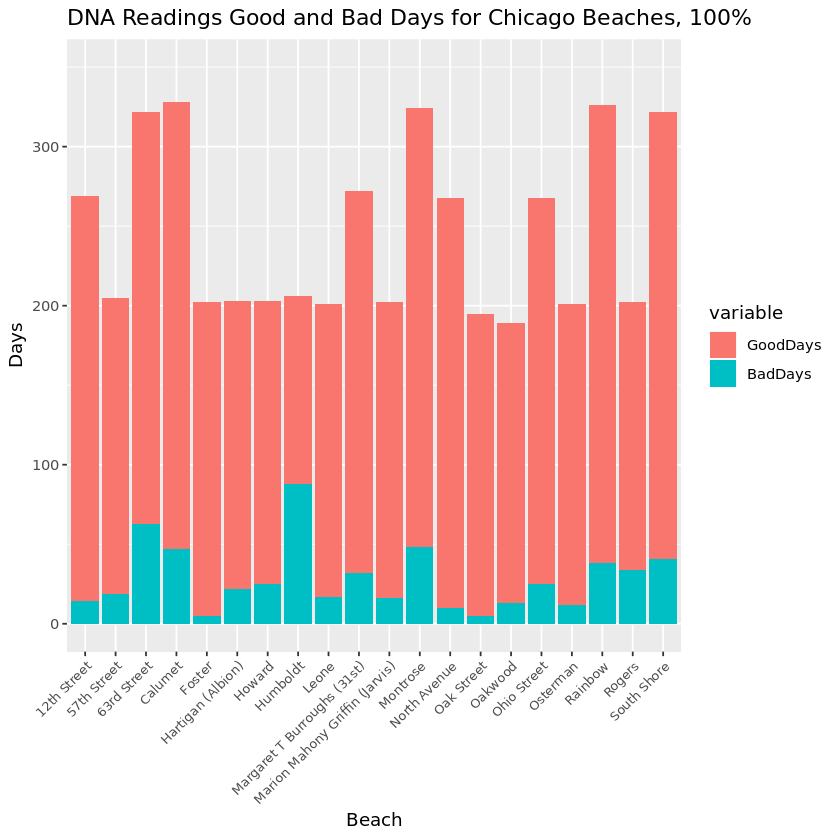

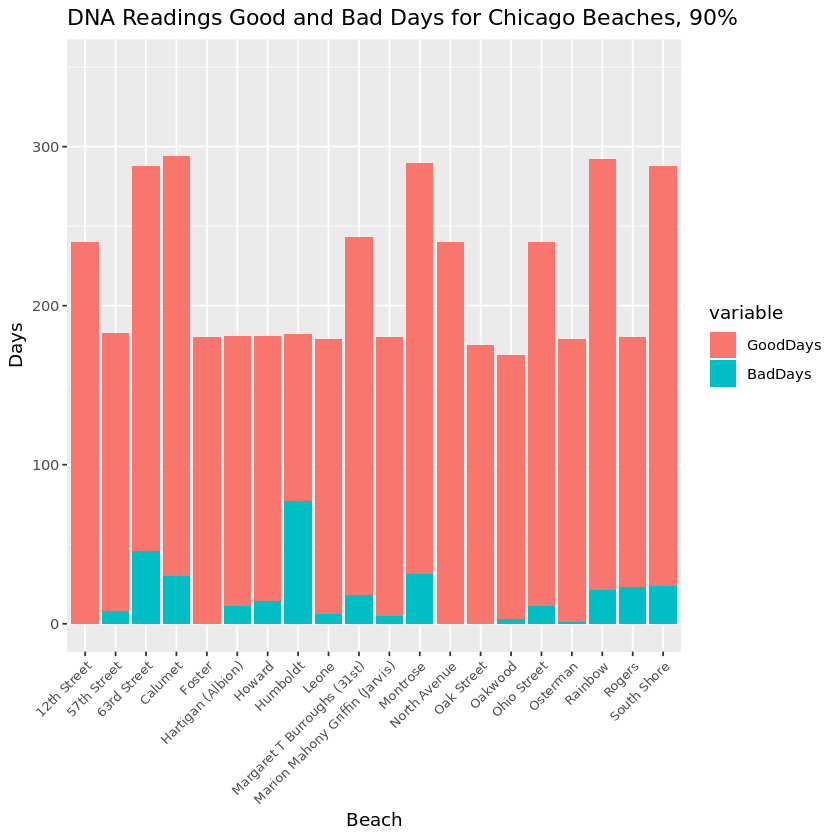

In [18]:
plotGBDays<-function(df,type){
  #reshaping data to work for bar plot
  df = subset(df,select=c(Beach,GoodDays,BadDays))
  df = melt(df,id.var="Beach")
  
  plot = ggplot(data=df, aes(x= Beach, y=value, fill=variable))+
    geom_bar(stat="identity")+
    ylab("Days")+
    theme(axis.text.x = element_text(size=8,angle=45, hjust=1))+
    coord_cartesian(ylim = c(0, 350)) +
    ggtitle(paste0("DNA Readings Good and Bad Days for Chicago Beaches, ",type,"%"))
  return(plot)
}

gbAll <- plotGBDays(beachesGoodBadDaysAll,"100")
gb90 <- plotGBDays(beachesGoodBadDays90,"90")
gb10 <- plotGBDays(beachesGoodBadDays10,"10")

gbAll
gb90

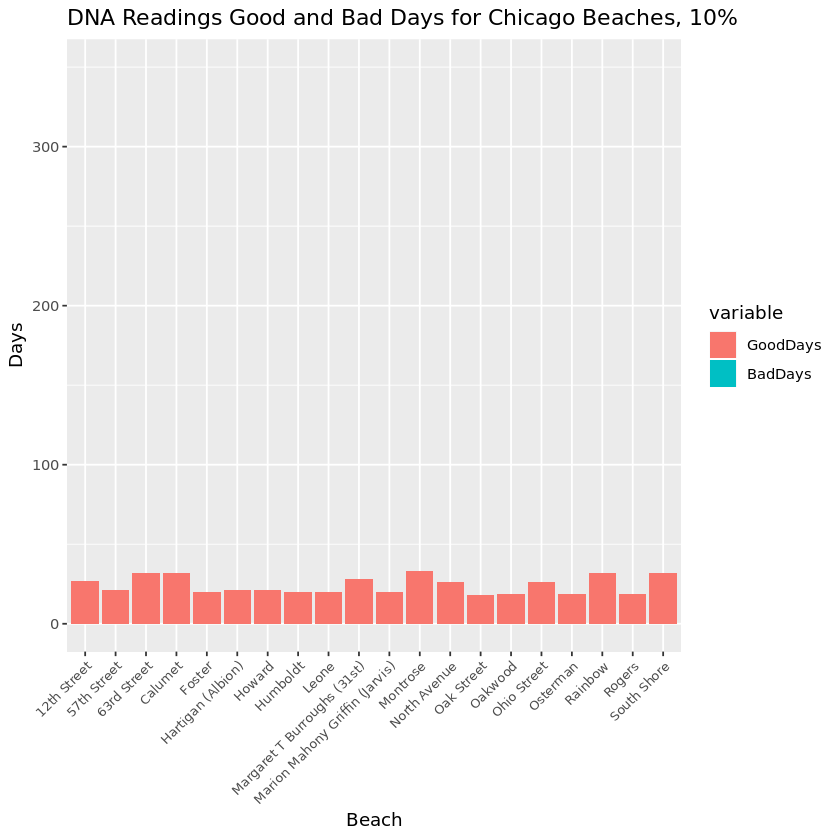

In [19]:
gb10

Looking at the 100% data and 90% common data is more beneficial here as outliers and high readings are more likely to indicate DNA reading levels ABOVE the advisory limit, rather than below the advisory limit. 

#### Again, there are overall many more good days than bad days for each beach, besides Humboldt, which nears half good days and half bad days.

End